Lo scopo dell'esercizio è quello di risolvere il problema del commesso viaggiatore (TSP) scegliendo un itinerario che comprenda tutti i capoluoghi di provincia dell'Italia ($N=110$ città).  
Ho deciso di tenere conto del fatto che la Terra è sferica per calcolare le distanze.  
Ho quindi usato le metriche: 
$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} (||\vec{x}_i-\vec{x}_{i+1}||_{GC} )^2
$$

$$
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} ||\vec{x}_i-\vec{x}_{i+1}||_{GC}
$$

Dove: 
$$||\vec{x}_A-\vec{x}_B||_{GC}:=\arccos(sin(\theta_A) \sin(\theta_B)+ \cos(\theta_A)\cos(\theta_B)\cos(\phi_A - \phi_B))$$ 
considerando i domini:  
$\phi \in [- \pi; \pi)$  
$\theta \in [- \frac{\pi}{2}; \frac{\pi}{2})$.  

Questa formula assume di misurare le distaze in unità naturali:  
$r^*=\frac{r}{R_T}$ in cui $R_T$ è il raggio terrestre.  
Ho anche provato a minimizzare le metrice dell'esercizio 9 applicate a latitudine e longitudine e ho visto che i risultati apparivano molto simili. Questo è dovuto al fatto che l'Italia è piccola rispetto al globo e quindi posso considerare una geometria piatta.   
A questo scopo si usa la libreria: "MPI" che permette di usare un modello SPMD per l'esecuzione in parallelo.  

# 10.1

La maggiorparte del codice è rimasta inalterata, tuttavia, poichè sfrutto generatori di numeri pseudo casuali, è stato necessario fare in modo che ogni nodo usi un seme diverso per generare numeri.  
Ad ogni nodo ho quindi fatto prendere dal file "Primes" la coppia di numeri scritti sulla riga corrispondente al rank del nodo + 1.  
Inoltre il codice nella cartella: "migration" prende un ulteriore input: $N_{migr}$ questo valore mi dice ogni quante generazioni le popolazioni di diversi nodi devono scambiarsi il miglior individuo.  
Lo scambio avviene tra coppie di nodi estratte casualmente in modo tale che ogni nodo sia in una sola coppia e che scambi e riceva dallo stesso nodo.  
Il mio portatile ha 10 cores, ma non ho voluto usarli tutti. Inoltre voglio che in numero di nodi sia un multiplo di due (per far si che ogni nodo partecipi agli scambi).  Per questo motivo il codice è pensato per usare 8 nodi.  
Subito dopo lo scambio l'individuo appena arrivato viene ordinato in base alla sua loss function (la quale non è calcolata ma viene passata insieme al gene dell'individuo).  

# 10.2

Per far funzionare il codice è necessario che nel file di input vi siano scritte solo le cordinate dei luoghi da visitare.

La simulazione è stata eseguita sia facendo risolvere il TSP indipendentemente ai diversi cores (cartella: "indipendent"), sia scambiando individui (cartella: "migration").  
La compilazione dei file è automatica tramite il comando: "make simulate" mentre l'esecuzione tramite: "make esegui_sim".  


## tutti i nodi

### salvataggio dati

In [132]:
# creo il vettore che mi trasforma gli interi nelle posizioni delle città (l'elemento i contiene le cordinate della città  con numero i+1)


tr=[]

with open("./indipendent/INPUT/cap_prov_ita.dat") as file:
	righe=file.read().split("\n")
	for l in righe:
		if(l!=""):
			try:
				# print(l.split("\t"))
				b,c=l.split() #split() separa se ho cose tra 1 o più spazi vuoti
				# print(i)
				posit=[] # posizione

				posit.append(float(b))
				posit.append(float(c))
				tr.append(posit)
			except ValueError:
				print(f"Il valore '{l}' non può essere convertito in float.")

In [133]:
# immagazzino i dati

#da eseguire dopo aver eseguito il blocco precedente

# dal più esterno al più interno:
# metodo
# metrica
# cores

import numpy as np

N = 8 # numero di blocchi usati

metod=["indipendent", "migration"]
metrica=["L1", "L2"]
cores=np.arange(N)
# ognuna di queste proprietà sarà in una lista che divide le due metriche e ognuna di queste in una lista che divide le due metodologie   

best=[] # al variare del metodo e della metrica e dello shape mi dice le cordinate del miglior individuo
for l in range(len(metod)):
	best_fixed_metod=[]
	for i in range(len(metrica)):
		best_fixed_metric=[]
		for j in range(len(cores)):
			with open(f"./{metod[l]}/OUTPUT/{metrica[i]}/best_travel_core{cores[j]}.out", 'r') as file:
				indiv=[]
				numbers=file.read().split(" ")
				for k in numbers:
					if(k!="\n"):
						indiv.append(tr[int(k) - 1])
				best_fixed_metric.append(indiv)
		best_fixed_metod.append(best_fixed_metric)
	best.append(best_fixed_metod)



### grafici

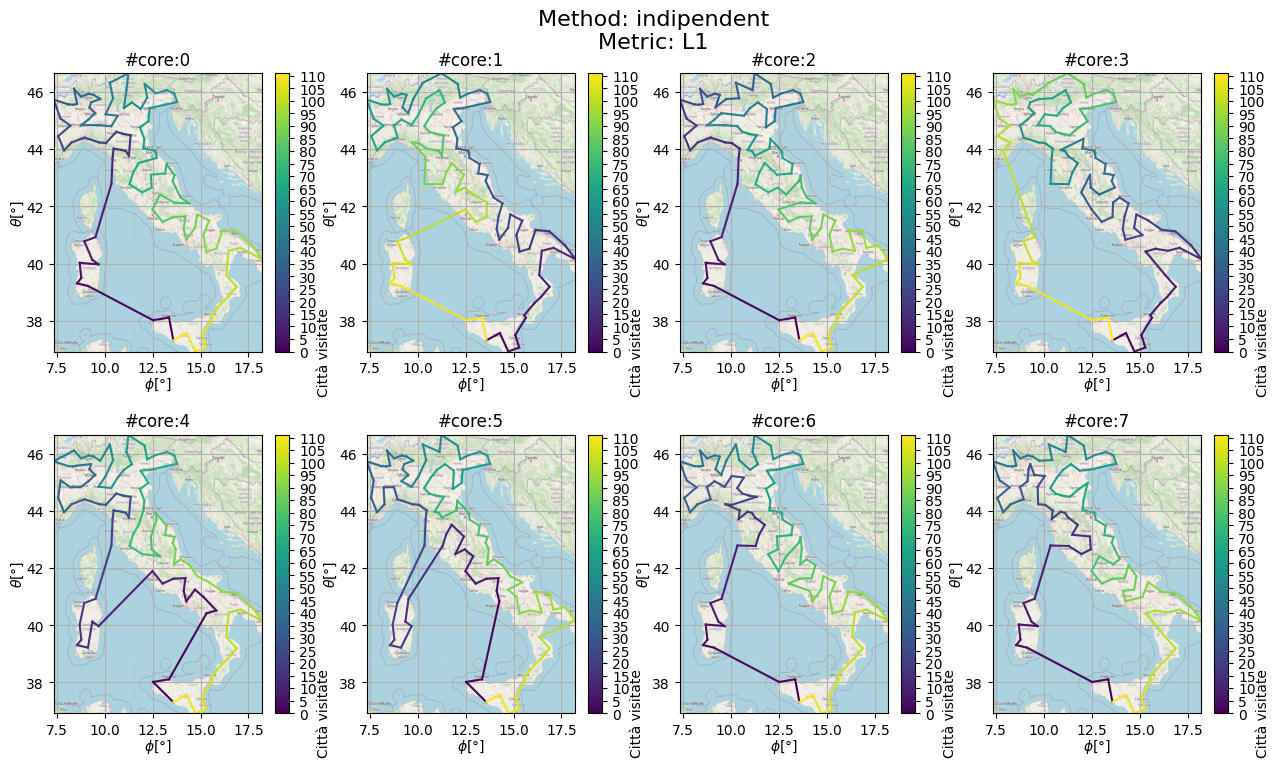

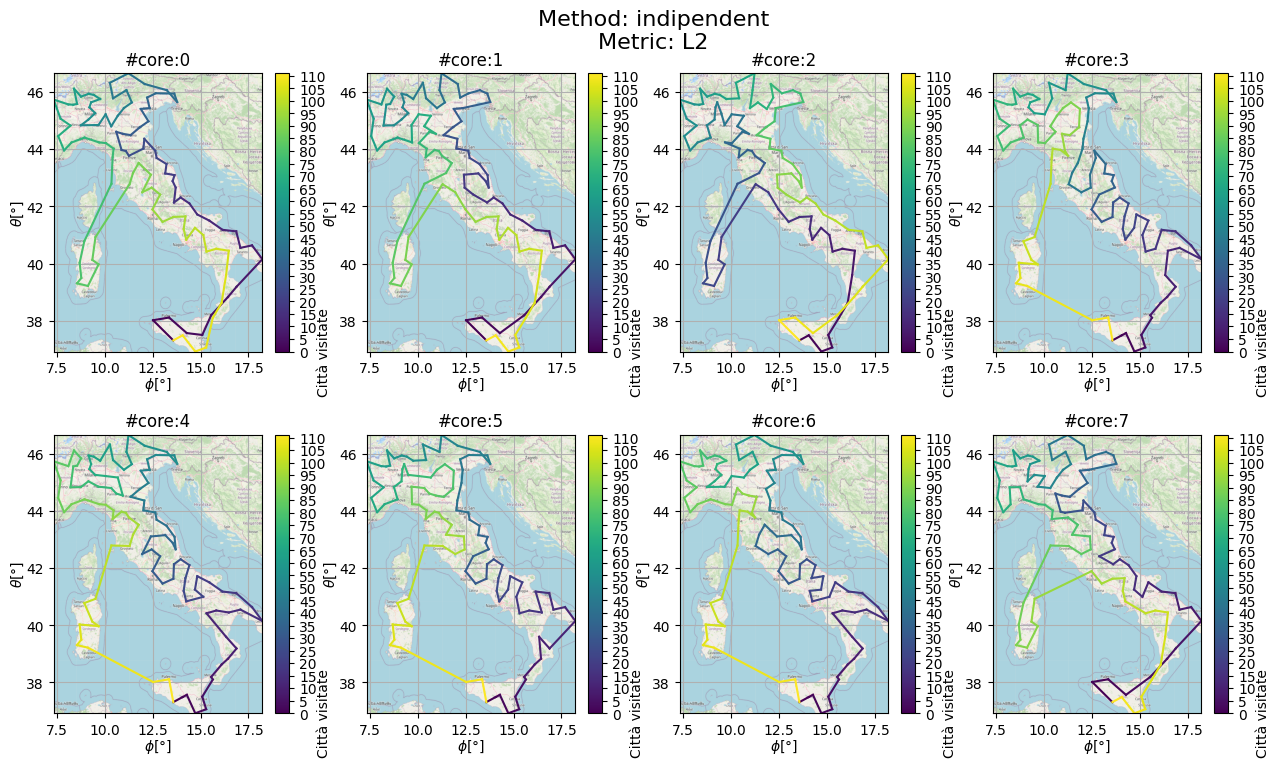

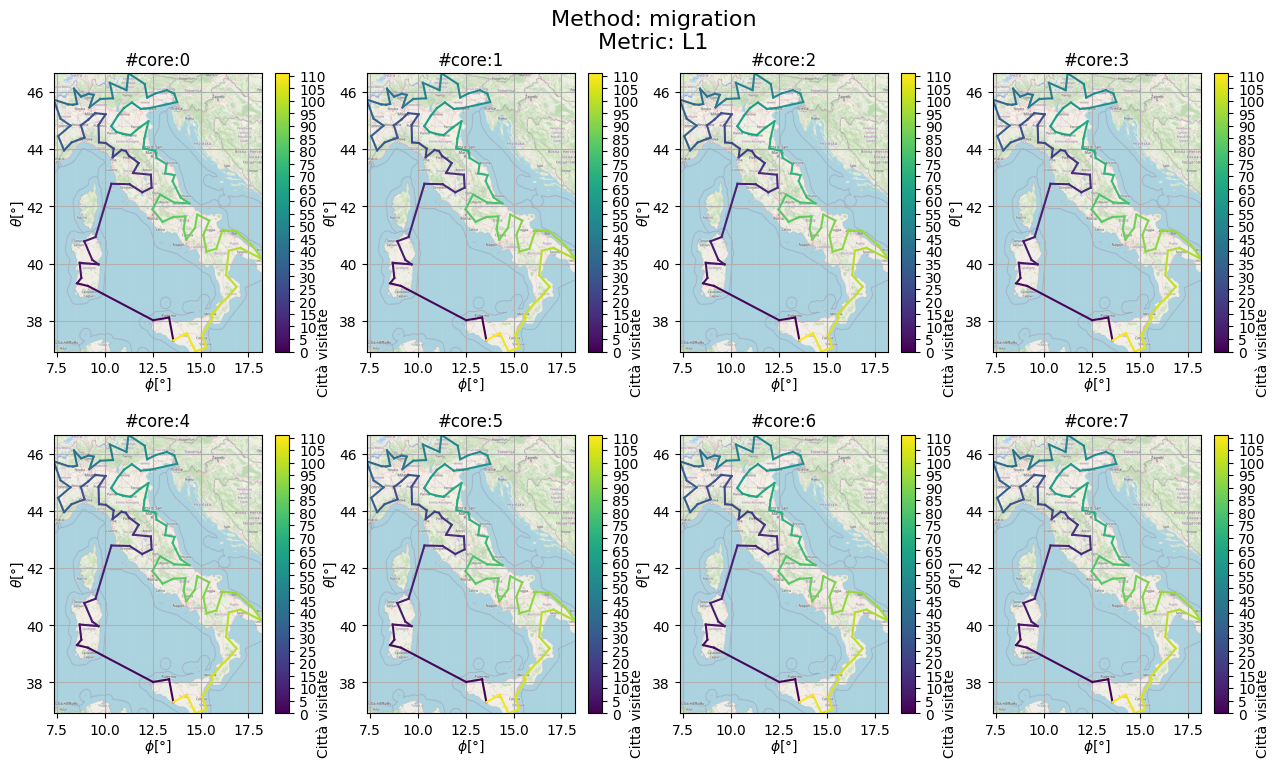

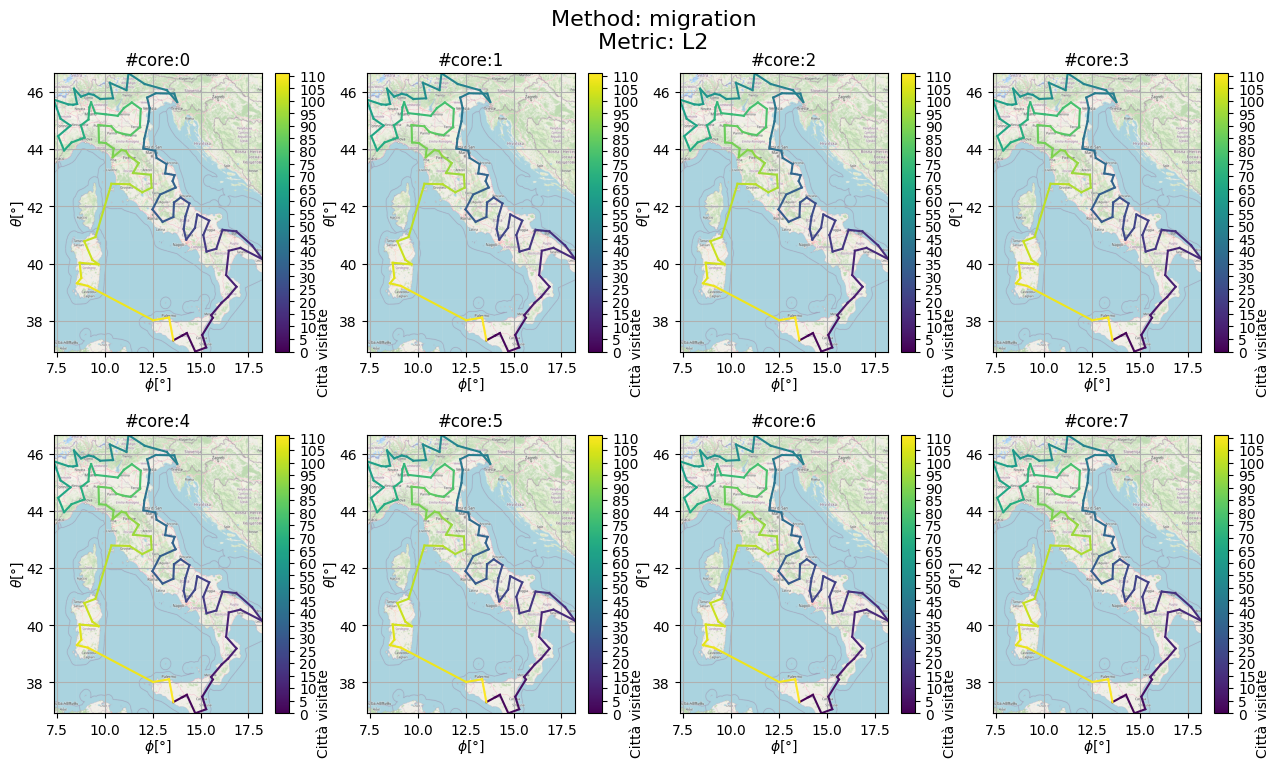

In [134]:
# da eseguire dopo il salvataggio dati

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg


def load_png_image(png_path):
    return mpimg.imread(png_path)

num_metod = len(metod)
num_metrica = len(metrica)
num_cores = len(cores)

# print(axes)

background_image = load_png_image('italy.png')

for l in range(len(metod)):
	for i in range(len(metrica)):
		fig, axes = plt.subplots(2, int(num_cores/2), figsize=(15, 8))
		axes = axes.flatten()

		plot_index =0
		for j in range(len(cores)):

			x, y = zip(*best[l][i][j])

			# Creazione di un array che rappresenta la progressione dei punti
			progress = np.linspace(0, 1, len(best[l][i][j]) + 1)

			# Creazione della colormap
			cmap = plt.get_cmap('viridis')

			# Colori basati sulla progressione dei punti
			colors = cmap(progress)

			# fig, ax = plt.subplots()
			ax = axes[plot_index]
			plot_index += 1
			ax.imshow(background_image, extent=[min(x), max(x), min(y), max(y)], aspect='auto')

			# Disegno la traiettoria con un gradiente di colore
			for k in range(len(best[l][i][j]) - 1):
				ax.plot(x[k:k+2], y[k:k+2], color=colors[k]) # prese coppie di elementi

			ax.plot([x[-1], x[0]], [y[-1], y[0]], color=colors[len(best[l][i][j])])

			# Disegno la barra di colori
			norm_cl = plt.Normalize(0, len(best[l][i][j]) + 1) # stabilito range di colori
			cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm_cl), ax=ax)  # barra di colori
			cb.set_label('Città visitate')
			cb.set_ticks(range(0, len(best[l][i][j]) + 1, 5))
			cb.ax.yaxis.set_label_coords(3, 0)

			# Aggiungi un titolo e le etichette agli assi
			ax.set_title(f"#core:{cores[j]}")
			ax.set_xlabel(r'$\phi[°]$', labelpad=0)
			ax.set_ylabel(r'$\theta[°]$', labelpad=0)

			# Mostra la griglia
			ax.grid(True)

		fig.suptitle(f"Method: {metod[l]}\nMetric: {metrica[i]}", fontsize=16)
		plt.tight_layout()
		plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.2)
		plt.show()


Nel caso in cui i nodi cercano una soluzione indipendentemente questi ottengono risultati molto più diversificati rispetto al caso in cui i nodi si scambiano individui fra loro. Questi ultimi hanno infatto trovato lo stesso miglior individuo.  

## migliori nodi

### salvataggio dati

In [139]:
# metodo:
# metrica:
# core:


i_best_core=[] # contiene l'indice con il core che ha fatto meglio nell'ultima simulazione
best_value=0
best_value_av=0
best_ev=[]# evoluzione della migliore distranza
av_ev=[]# evoluzione della media tra la metà migliore
gen=[] # vettore con il numero delle generazioni
# ognuna di queste proprietà sara in una lista che divide le due forme e ognuna di queste in una lista che divide le due metriche

metod=["indipendent", "migration"]
metrica=["L1", "L2"]
cores=np.arange(N)


popolation=1000

		
for l in range(len(metod)):
	best_ev_fixed_metod=[]
	av_fixed_metod=[]
	gen_fixed_metod=[]
	i_best_core_fixed_metod=[]
	for i in range(len(metrica)):
		best_ev_fixed_metrica=[]
		av_fixed_metrica=[]
		gen_fixed_metrica=[]
		for j in range(len(cores)):
			with open(f"./{metod[l]}/OUTPUT/{metrica[i]}/evolution_core{cores[j]}.out", 'r') as file:
				best_ev_fixed_core=[]
				av_fixed_core=[]
				gen_fixed_core=[]
				righe=file.read().split("\n")
				for k in righe:
					if(k!="" and k!=f'    # generation:          shortest_distance:          average_of_top_{popolation}:'):
						try:
							a,b,c=k.split()
							gen_fixed_core.append(int(a))
							best_ev_fixed_core.append(float(b))
							av_fixed_core.append(float(c))	
						except ValueError:
							non_scrivere_nulla=True # fatta una operazione a caso
							# print(f"Il valore '{k}' non può essere convertito in float.")
				best_ev_fixed_metrica.append(best_ev_fixed_core)
				av_fixed_metrica.append(av_fixed_core)
				gen_fixed_metrica.append(gen_fixed_core)

				if(j==0):
					best_value=best_ev_fixed_core[len(best_ev_fixed_core)-1]
					best_value_av=av_fixed_core[len(av_fixed_core)-1]
					i_best_core_fixed_metrica=0
				else:
					if(best_ev_fixed_core[len(best_ev_fixed_core)-1] < best_value or (best_ev_fixed_core[len(best_ev_fixed_core)-1] == best_value and av_fixed_core[len(av_fixed_core) - 1] < best_value_av)):
							i_best_core_fixed_metrica=j
							best_value=best_ev_fixed_core[len(best_ev_fixed_core)-1]
							best_value_av=av_fixed_core[len(av_fixed_core)-1]

			

		best_ev_fixed_metod.append(best_ev_fixed_metrica)
		av_fixed_metod.append(av_fixed_metrica)
		gen_fixed_metod.append(gen_fixed_metrica)
		i_best_core_fixed_metod.append(i_best_core_fixed_metrica)
		

	best_ev.append(best_ev_fixed_metod)
	av_ev.append(av_fixed_metod)
	gen.append(gen_fixed_metod)
	i_best_core.append(i_best_core_fixed_metod)

print(f"nodi che contiengono i migliori individui:\n")

for l in range(len(metod)):
	for i in range(len(metrica)):
		print(f"metodo: {metod[l]}\nmetrica: {metrica[i]}\nblocco migliore:{i_best_core[l][i]}\n")


nodi che contiengono i migliori individui:

metodo: indipendent
metrica: L1
blocco migliore:7

metodo: indipendent
metrica: L2
blocco migliore:5

metodo: migration
metrica: L1
blocco migliore:3

metodo: migration
metrica: L2
blocco migliore:3



### grafici

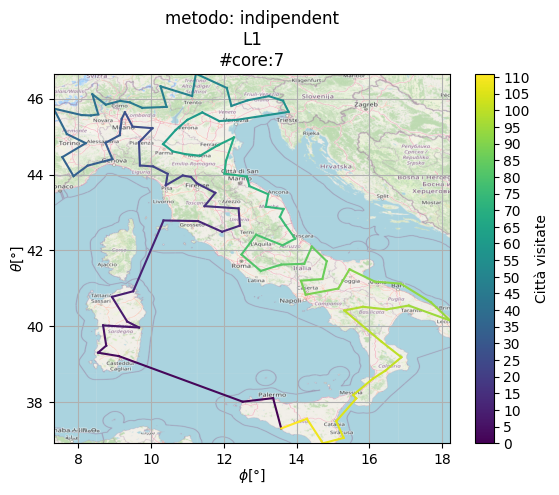

0.9608298413042341


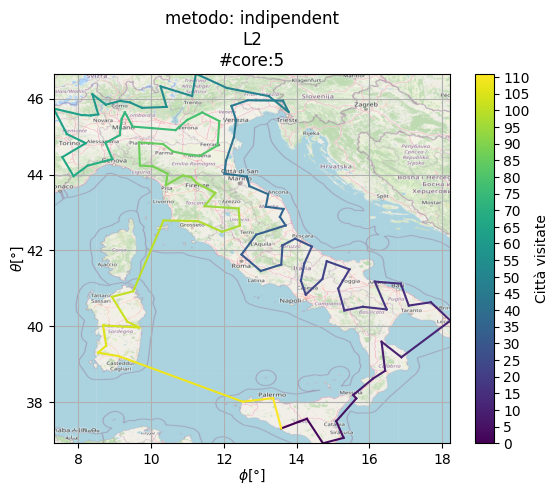

0.01222164236988816


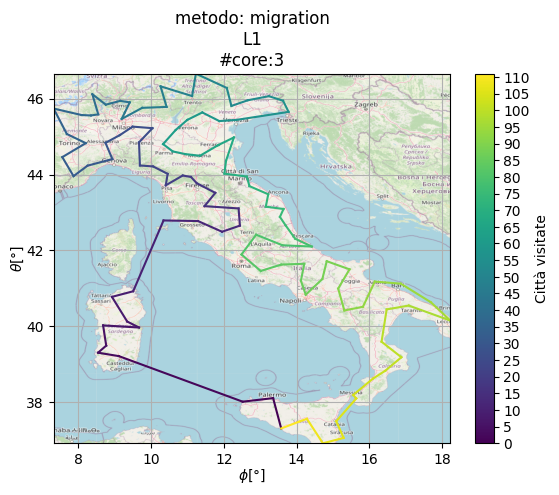

0.9604474642077083


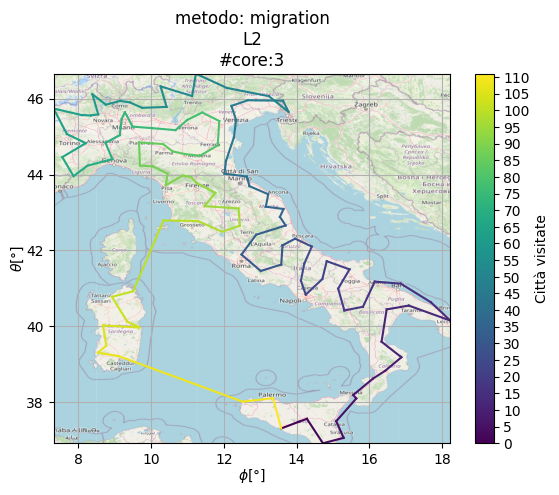

0.01198604519505927


In [140]:
# da eseguire dopo il salvataggio dati

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg


def load_png_image(png_path):
    return mpimg.imread(png_path)

background_image = load_png_image('italy.png')
for l in range(len(metod)):
	for i in range(len(metrica)):

		x, y = zip(*best[l][i][i_best_core[l][i]])

		# Creazione di un array che rappresenta la progressione dei punti
		progress = np.linspace(0, 1, len(best[l][i][cores[i_best_core[l][i]]]) + 1)

		# Creazione della colormap
		cmap = plt.get_cmap('viridis')

		# Colori basati sulla progressione dei punti
		colors = cmap(progress)

		fig, ax = plt.subplots()

		ax.imshow(background_image, extent=[min(x), max(x), min(y), max(y)], aspect='auto')

		# Disegno la traiettoria con un gradiente di colore
		for k in range(len(best[l][i][cores[i_best_core[l][i]]]) - 1):
			plt.plot(x[k:k+2], y[k:k+2], color=colors[k]) # prese coppie di elementi

		plt.plot([x[-1], x[0]], [y[-1], y[0]], color=colors[len(best[l][i][cores[i_best_core[l][i]]])])

		# Disegno la barra di colori
		norm_cl = plt.Normalize(0, len(best[l][i][cores[i_best_core[l][i]]]) + 1) # stabilito range di colori
		# print(f"{cores[i_best_core[l][i]]} {l} {i}")
		cb = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm_cl), ax=ax)  # barra di colori
		cb.set_label('Città visitate')
		cb.set_ticks(range(0, len(best[l][i][cores[i_best_core[l][i]]]) + 1, 5))


		# Aggiungo un titolo e le etichette agli assi
		ax.set_title(f"metodo: {metod[l]}\n{metrica[i]}\n#core:{cores[i_best_core[l][i]]}")
		ax.set_xlabel(r'$\phi[°]$', labelpad=0)
		ax.set_ylabel(r'$\theta[°]$', labelpad=0)

		# Mostro la griglia
		ax.grid(True)

		# Visualizzare la traiettoria
		plt.show()
		print(best_ev[l][i][i_best_core[l][i]][len(best_ev_fixed_core)-1])



I risultati sono migliori quando i nodi si scambiano individui, che è quello che ci aspettiamo.